# Introduction
To test the validity of our algorithm to model an semi-flexible and extensible bead-spring chain, we first study a straight trimer with a known rigidity and spring constant between bonds. 

Beads 0,1,2 are connected in series with the preferred angle between line segments 0-1 and 1-2 being zero.

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import physical_scales as ps

# Graph style settings
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

torch device: cpu


# Data

In [31]:
data_dir = Path.home() / "projects/DATA/my_alens_data"
data_dir_list = [
    data_dir / "BrownianDimer",
    data_dir / "BrownianTrimer",
    data_dir / "SemiFlexTrimer",
]
for i in data_dir_list:
    assert i.exists(), f"{i} does not exist"


In [33]:
# Collect raw data using alens_analysis
for i in data_dir_list:
    opts = lambda: None # Create an empty object to store analysis options
    opts.path = i
    opts.analysis = 'collect' # This replicates the -A flag when running `analens -A collect`
    opts.analysis_dir = opts.path / 'analysis' # Specify where to store the analysis files
    opts.analysis_dir.mkdir(exist_ok=True) # Make sure the analysis directory exists
    opts.overwrite = True # Overwrite existing analysis files

    aa.seed_analysis(opts)

raw_BrownianDimer
Made time data set in 0.016568660736083984 seconds.
Made sylinder data set in 0.06543731689453125 seconds.
Made protin data set in 0.03769087791442871 seconds.
Made raw data file in a total of 0.11983585357666016 seconds.
 HDF5 raw created in 0.15692996978759766
raw_BrownianTrimer
Made time data set in 0.012881040573120117 seconds.
Made sylinder data set in 0.043730974197387695 seconds.
Made protin data set in 0.022738933563232422 seconds.
Made raw data file in a total of 0.07950091361999512 seconds.
 HDF5 raw created in 0.10224413871765137
raw_SemiFlexTrimer
Made time data set in 0.013610601425170898 seconds.
Made sylinder data set in 0.014275074005126953 seconds.
Made protin data set in 0.009775161743164062 seconds.
Made raw data file in a total of 0.03780770301818848 seconds.
 HDF5 raw created in 0.05273699760437012


0.033111185


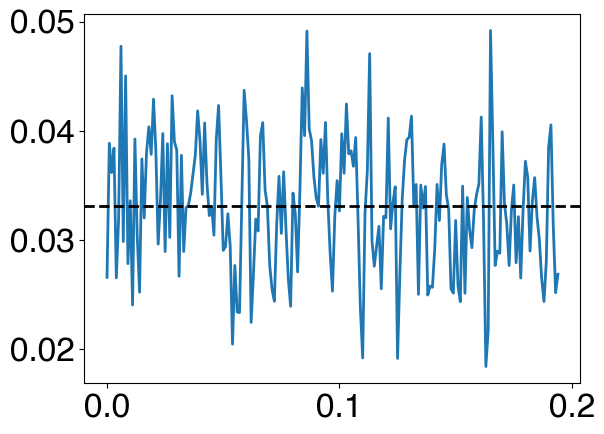

In [34]:
with h5py.File(next(data_dir_list[0].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] # Load in time array, [:] loads data as numpy array
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dist_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
    plt.plot(time_arr, dist_arr)
    plt.axhline(dist_arr.mean(), color='k', linestyle='--')
    print(dist_arr.mean())

# Functions